<h3>Feature Engineering & Model Selection</h3>

<h3>Importing Libraries</h3>

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import statistics
from scipy.stats import pearsonr, shapiro
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


<h3>Reading Data</h3>

In [277]:
# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="###",
    resource_group_name="###",
    workspace_name="###",
)

In [278]:
version = "Feature_Selected_Data"
# get a handle of the data asset and print the URI
data_asset = ml_client.data.get(name="Car-Data", version=version)
print(f"Data asset URI: {data_asset.path}")

# read into pandas - note that you will see 2 headers in your data frame - that is ok, for now

df = pd.read_csv(data_asset.path)

Data asset URI: azureml://subscriptions/144c7089-5d3d-40fa-bfaf-6ffb69774b59/resourcegroups/AML-sdk-v2-RG1/workspaces/AML-sdk-v2-RG1-WS1/datastores/workspaceblobstore/paths/LocalUpload/802a5ab2104c25cf07f29c2b30cd0c9e/Feature_Selected_Data.csv


<h3>Feature Transformation </h3>

In [279]:
df.columns

Index(['Unnamed: 0', 'Fuel_Type', 'Power(kw)', 'Max_Torque(nm)', 'Cylinders',
       'Engine_Capacity(cc)', 'Max_Power_Rpm', 'Max_Torque_Rpm', 'Fuel_System',
       'Turbo', 'Co2_Emissions(g/km)'],
      dtype='object')

In [280]:
df = df.drop("Unnamed: 0", axis = 1)

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fuel_Type            2377 non-null   object 
 1   Power(kw)            2377 non-null   float64
 2   Max_Torque(nm)       2377 non-null   float64
 3   Cylinders            2377 non-null   object 
 4   Engine_Capacity(cc)  2377 non-null   float64
 5   Max_Power_Rpm        2377 non-null   float64
 6   Max_Torque_Rpm       2377 non-null   float64
 7   Fuel_System          2377 non-null   object 
 8   Turbo                2377 non-null   object 
 9   Co2_Emissions(g/km)  2377 non-null   float64
dtypes: float64(6), object(4)
memory usage: 185.8+ KB


##### <pre>One-Hot Encoding - Categorical Features</pre>

In [282]:
Categorical_df = df.select_dtypes(include=['object'])
Numerical_df = df.select_dtypes(include=['int', 'float'])

In [283]:
Numerical_df

,Power(kw),Max_Torque(nm),Engine_Capacity(cc),Max_Power_Rpm,Max_Torque_Rpm,Co2_Emissions(g/km)
0,99.0,206.0,1368.0,5500.000000,3000.0,155.0
1,114.0,201.0,1368.0,5750.000000,3000.0,162.0
2,121.0,250.0,1368.0,5500.000000,2250.0,142.0
3,121.0,206.0,1970.0,6400.000000,3250.0,212.0
4,76.0,124.0,1370.0,6300.000000,4600.0,189.0
...,...,...,...,...,...,...
2372,180.0,400.0,1395.0,5000.000000,1550.0,30.0
2373,180.0,400.0,1395.0,5000.000000,1550.0,31.0
2374,103.0,260.0,1333.0,4500.000000,1750.0,134.0
2375,103.0,260.0,1333.0,4500.000000,1750.0,138.0


In [284]:
Categorical_df

,Fuel_Type,Cylinders,Fuel_System,Turbo
0,gasoline,"4, in line",multipoint injection,"yes, with intercooler"
1,gasoline,"4, in line",multipoint injection,"yes, with intercooler"
2,gasoline,"4, in line",multipoint injection,"yes, with intercooler"
3,gasoline,"4, in line",direct injection,no
4,gasoline,"4, in line",multipoint injection,no
...,...,...,...,...
2372,gasoline,"4, in line",direct injection,"yes, with intercooler"
2373,gasoline,"4, in line",direct injection,"yes, with intercooler"
2374,gasoline,"4, in line",direct injection,"yes, with intercooler"
2375,gasoline,"4, in line",direct injection,"yes, with intercooler"


In [285]:
Categorical_Encoded_df = pd.get_dummies(Categorical_df, drop_first=True, dtype = int)

In [286]:
Categorical_Encoded_df

,Fuel_Type_gasoline,Fuel_Type_gasoline / bio ethanol,Fuel_Type_lpg / gasoline,"Cylinders_12, v engine","Cylinders_12, w engine","Cylinders_16, w engine","Cylinders_2, in line",Cylinders_3,"Cylinders_3, in line",Cylinders_4,...,"Cylinders_8, w engine",Fuel_System_direct injection,Fuel_System_indirect injection,Fuel_System_multijet,Fuel_System_multipoint injection,Fuel_System_singplepoint injection,Turbo_no,Turbo_yes,"Turbo_yes, two","Turbo_yes, with intercooler"
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2372,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2373,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2374,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2375,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [287]:
Final_df = pd.concat((Numerical_df, Categorical_Encoded_df), axis=1)

In [288]:
Final_df.head(2)

,Power(kw),Max_Torque(nm),Engine_Capacity(cc),Max_Power_Rpm,Max_Torque_Rpm,Co2_Emissions(g/km),Fuel_Type_gasoline,Fuel_Type_gasoline / bio ethanol,Fuel_Type_lpg / gasoline,"Cylinders_12, v engine",...,"Cylinders_8, w engine",Fuel_System_direct injection,Fuel_System_indirect injection,Fuel_System_multijet,Fuel_System_multipoint injection,Fuel_System_singplepoint injection,Turbo_no,Turbo_yes,"Turbo_yes, two","Turbo_yes, with intercooler"
0,99.0,206.0,1368.0,5500.0,3000.0,155.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,114.0,201.0,1368.0,5750.0,3000.0,162.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


### Model Selection

In [289]:
Model_Error_rates = {}

#### Linear Regression

##### Assumptions Of linear regression

1. Linear relationship between features and target.
2. No Multicollinearity between the features.
3. Homoscedasticity.
4. No Autocorrelation.
5. Predictors are distributed normally.

1. Linear relationship between features and target


To check for linear relationship between features and target we will use Pearson correlation coefficient. 

In [290]:
Final_df.columns

Index(['Power(kw)', 'Max_Torque(nm)', 'Engine_Capacity(cc)', 'Max_Power_Rpm',
       'Max_Torque_Rpm', 'Co2_Emissions(g/km)', 'Fuel_Type_gasoline',
       'Fuel_Type_gasoline / bio ethanol', 'Fuel_Type_lpg / gasoline',
       'Cylinders_12, v engine', 'Cylinders_12, w engine',
       'Cylinders_16, w engine', 'Cylinders_2, in line', 'Cylinders_3',
       'Cylinders_3, in line', 'Cylinders_4', 'Cylinders_4, boxer',
       'Cylinders_4, in line', 'Cylinders_4, v engine', 'Cylinders_5, in line',
       'Cylinders_6', 'Cylinders_6, boxer', 'Cylinders_6, in line',
       'Cylinders_6, v engine', 'Cylinders_8, in line',
       'Cylinders_8, v engine', 'Cylinders_8, w engine',
       'Fuel_System_direct injection', 'Fuel_System_indirect injection',
       'Fuel_System_multijet', 'Fuel_System_multipoint injection',
       'Fuel_System_singplepoint injection', 'Turbo_no', 'Turbo_yes',
       'Turbo_yes, two', 'Turbo_yes, with intercooler'],
      dtype='object')

In [291]:
def check_linear_relationship(columns):
    Result = {}
    for column in columns:
        if column != "Co2_Emissions(g/km)":
            Test_Result = pearsonr(df[column], df["Co2_Emissions(g/km)"])
            Result[column] = Test_Result
    return Result

In [292]:
columns = Numerical_df.columns
check_linear_relationship(columns)

{'Power(kw)': (0.621586371559939, 3.627950253742235e-254),
 'Max_Torque(nm)': (0.5799720487666041, 9.756990709361093e-214),
 'Engine_Capacity(cc)': (0.8315389329199923, 0.0),
 'Max_Power_Rpm': (0.23223131605784547, 1.7911159574183147e-30),
 'Max_Torque_Rpm': (0.22433086784710807, 1.7000816098202115e-28)}

2. To check for multi-collinearity

We will use heatmap to detect multicollinearity between features.

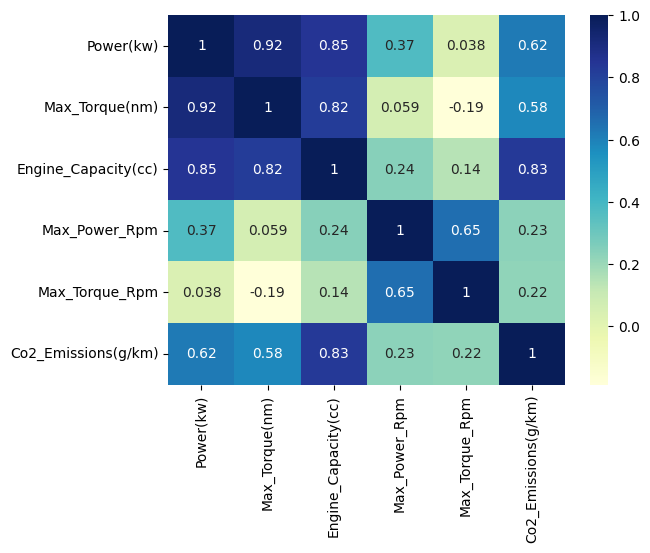

In [293]:
Correlation_Matrix = Numerical_df.corr()
sns.heatmap(Correlation_Matrix, annot=True, cmap="YlGnBu")
plt.show()

<pre>Features with multi-collinearity:
1. Power(kw) & Max_Torque(nm) -> 0.92
2. Power(kw) & Engine_Capacity(cc) -> 0.85
3. Max_Torque(nm) & Engine_Capacity(cc) -> 0.82
  

We will remove Power(kw) & Max_Torque(nm) since they have lower correlation than engine capacity(cc) with target feature Co2_Emissions(g/km)" 

In [294]:
Linear_Reg_df = Final_df.copy()
Linear_Reg_df = Linear_Reg_df.drop(["Power(kw)","Max_Torque(nm)"], axis = 1)
Linear_Reg_df.head(2)

,Engine_Capacity(cc),Max_Power_Rpm,Max_Torque_Rpm,Co2_Emissions(g/km),Fuel_Type_gasoline,Fuel_Type_gasoline / bio ethanol,Fuel_Type_lpg / gasoline,"Cylinders_12, v engine","Cylinders_12, w engine","Cylinders_16, w engine",...,"Cylinders_8, w engine",Fuel_System_direct injection,Fuel_System_indirect injection,Fuel_System_multijet,Fuel_System_multipoint injection,Fuel_System_singplepoint injection,Turbo_no,Turbo_yes,"Turbo_yes, two","Turbo_yes, with intercooler"
0,1368.0,5500.0,3000.0,155.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1368.0,5750.0,3000.0,162.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


3. To check for Homoscedasticity

Refers to a condition in which variance of the residuals in a regression model is constant. We will check it after building the Linear Regression (OGD) 
model.

4. No auto correlation

Refers to a condition in which residuals are dependent on each other. We will check it after building the Linear Regression (OGD) 
model.

5. Multivariate Normality

We will use Shapiro-Wilks test to check for normality.

6. Residuals are normally Distributed.

We will use histogram to check for normality of residuals

In [295]:
def Shapiro_Test(columns):
    Result = {}
    for column in columns:
        Test = shapiro(Linear_Reg_df[column])
        Result[column] = Test
    return Result

In [296]:
Numeric_Linear_Reg_df = Linear_Reg_df[["Engine_Capacity(cc)","Max_Power_Rpm","Max_Torque_Rpm","Co2_Emissions(g/km)"]]
columns = Numeric_Linear_Reg_df.columns
Shapiro_Test(columns)

{'Engine_Capacity(cc)': ShapiroResult(statistic=0.7997592687606812, pvalue=0.0),
 'Max_Power_Rpm': ShapiroResult(statistic=0.9482992887496948, pvalue=3.8205741197928733e-28),
 'Max_Torque_Rpm': ShapiroResult(statistic=0.9373024106025696, pvalue=1.464045300107336e-30),
 'Co2_Emissions(g/km)': ShapiroResult(statistic=0.895675778388977, pvalue=1.9060724034818683e-37)}

Since the p-value is less than .05 for all the features, we reject the null hypothesis for every feature. We have sufficient evidence to say that the sample data does not come from a normal distribution for every feature, which means the features are skewed.

We will check for Skewness for this features and if the data is skewed then we will use log transform to change it to normal distribution.

1.Engine_Capacity(cc)

Engine_Capacity(cc) (mean) : 2095.3968075938096
Engine_Capacity(cc) (median) : 1796.0
Engine_Capacity(cc) (mode) : 1598.0
Engine_Capacity(cc) Skewness: 1.983579
Engine_Capacity(cc) Kurtosis: 4.650573


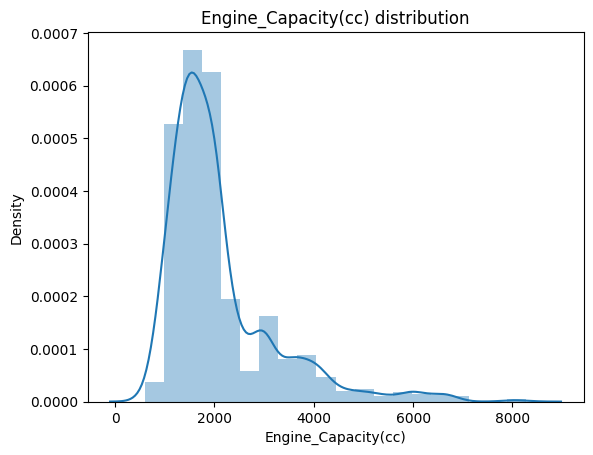

In [297]:
sns.distplot(Linear_Reg_df["Engine_Capacity(cc)"],bins = 20)
plt.title('Engine_Capacity(cc) distribution')
mean = statistics.mean(Linear_Reg_df['Engine_Capacity(cc)'])
median = statistics.median(Linear_Reg_df['Engine_Capacity(cc)'])
mode = statistics.mode(Linear_Reg_df['Engine_Capacity(cc)'])
print("Engine_Capacity(cc) (mean) :",mean)
print("Engine_Capacity(cc) (median) :",median)
print("Engine_Capacity(cc) (mode) :",mode)
print("Engine_Capacity(cc) Skewness: %f" % Linear_Reg_df['Engine_Capacity(cc)'].skew())
print("Engine_Capacity(cc) Kurtosis: %f" % Linear_Reg_df['Engine_Capacity(cc)'].kurt())

Since the Skewness is more than 1, we have to use Log Transform 

In [298]:
Linear_Reg_df["Normalized_Engine_Capacity(cc)"] = np.log1p(Linear_Reg_df["Engine_Capacity(cc)"]) 

Normalized_Engine_Capacity(cc) (mean) : 7.542871428569795
Normalized_Engine_Capacity(cc) (median) : 7.493873886783558
Normalized_Engine_Capacity(cc) (mode) : 7.377133712833954
Normalized_Engine_Capacity(cc) Skewness: 0.693233
Normalized_Engine_Capacity(cc) Kurtosis: 0.315666


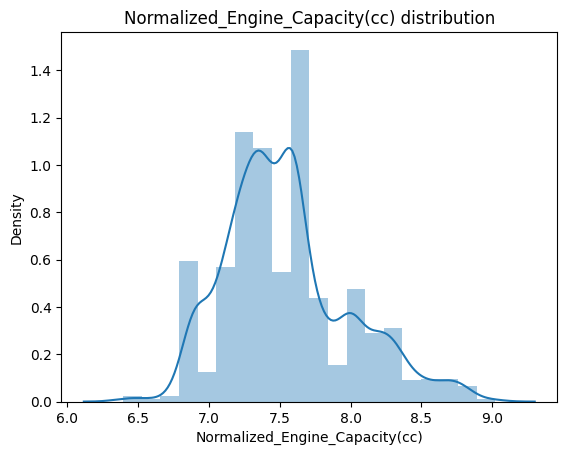

In [299]:
sns.distplot(Linear_Reg_df["Normalized_Engine_Capacity(cc)"],bins = 20)
plt.title('Normalized_Engine_Capacity(cc) distribution')
mean = statistics.mean(Linear_Reg_df['Normalized_Engine_Capacity(cc)'])
median = statistics.median(Linear_Reg_df['Normalized_Engine_Capacity(cc)'])
mode = statistics.mode(Linear_Reg_df['Normalized_Engine_Capacity(cc)'])
print("Normalized_Engine_Capacity(cc) (mean) :",mean)
print("Normalized_Engine_Capacity(cc) (median) :",median)
print("Normalized_Engine_Capacity(cc) (mode) :",mode)
print("Normalized_Engine_Capacity(cc) Skewness: %f" % Linear_Reg_df['Normalized_Engine_Capacity(cc)'].skew())
print("Normalized_Engine_Capacity(cc) Kurtosis: %f" % Linear_Reg_df['Normalized_Engine_Capacity(cc)'].kurt())

Normalized_Engine_Capacity(cc) has normal distribution.

In [300]:
Linear_Reg_df.columns

Index(['Engine_Capacity(cc)', 'Max_Power_Rpm', 'Max_Torque_Rpm',
       'Co2_Emissions(g/km)', 'Fuel_Type_gasoline',
       'Fuel_Type_gasoline / bio ethanol', 'Fuel_Type_lpg / gasoline',
       'Cylinders_12, v engine', 'Cylinders_12, w engine',
       'Cylinders_16, w engine', 'Cylinders_2, in line', 'Cylinders_3',
       'Cylinders_3, in line', 'Cylinders_4', 'Cylinders_4, boxer',
       'Cylinders_4, in line', 'Cylinders_4, v engine', 'Cylinders_5, in line',
       'Cylinders_6', 'Cylinders_6, boxer', 'Cylinders_6, in line',
       'Cylinders_6, v engine', 'Cylinders_8, in line',
       'Cylinders_8, v engine', 'Cylinders_8, w engine',
       'Fuel_System_direct injection', 'Fuel_System_indirect injection',
       'Fuel_System_multijet', 'Fuel_System_multipoint injection',
       'Fuel_System_singplepoint injection', 'Turbo_no', 'Turbo_yes',
       'Turbo_yes, two', 'Turbo_yes, with intercooler',
       'Normalized_Engine_Capacity(cc)'],
      dtype='object')

In [301]:
Linear_Reg_df= Linear_Reg_df.drop("Engine_Capacity(cc)", axis = 1)

In [302]:
Linear_Reg_df.columns

Index(['Max_Power_Rpm', 'Max_Torque_Rpm', 'Co2_Emissions(g/km)',
       'Fuel_Type_gasoline', 'Fuel_Type_gasoline / bio ethanol',
       'Fuel_Type_lpg / gasoline', 'Cylinders_12, v engine',
       'Cylinders_12, w engine', 'Cylinders_16, w engine',
       'Cylinders_2, in line', 'Cylinders_3', 'Cylinders_3, in line',
       'Cylinders_4', 'Cylinders_4, boxer', 'Cylinders_4, in line',
       'Cylinders_4, v engine', 'Cylinders_5, in line', 'Cylinders_6',
       'Cylinders_6, boxer', 'Cylinders_6, in line', 'Cylinders_6, v engine',
       'Cylinders_8, in line', 'Cylinders_8, v engine',
       'Cylinders_8, w engine', 'Fuel_System_direct injection',
       'Fuel_System_indirect injection', 'Fuel_System_multijet',
       'Fuel_System_multipoint injection',
       'Fuel_System_singplepoint injection', 'Turbo_no', 'Turbo_yes',
       'Turbo_yes, two', 'Turbo_yes, with intercooler',
       'Normalized_Engine_Capacity(cc)'],
      dtype='object')

2. Max_Power_Rpm

Max_Power_Rpm (mean) : 5526.097272253191
Max_Power_Rpm (median) : 5600.0
Max_Power_Rpm (mode) : 6000.0
Max_Power_Rpm Skewness: -0.233971
Max_Power_Rpm Kurtosis: 1.272961


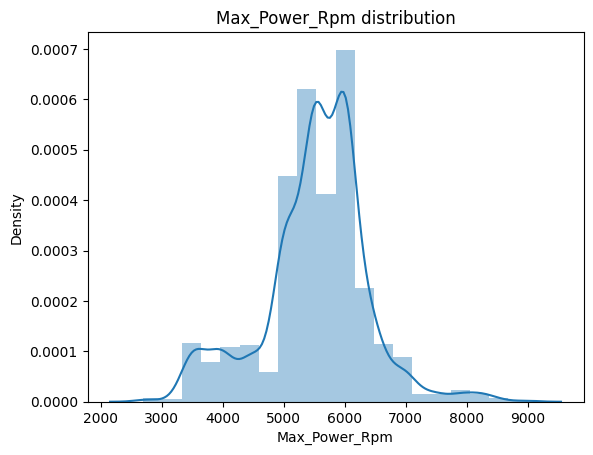

In [303]:
sns.distplot(Linear_Reg_df["Max_Power_Rpm"],bins = 20)
plt.title('Max_Power_Rpm distribution')
mean = statistics.mean(Linear_Reg_df['Max_Power_Rpm'])
median = statistics.median(Linear_Reg_df['Max_Power_Rpm'])
mode = statistics.mode(Linear_Reg_df['Max_Power_Rpm'])
print("Max_Power_Rpm (mean) :",mean)
print("Max_Power_Rpm (median) :",median)
print("Max_Power_Rpm (mode) :",mode)
print("Max_Power_Rpm Skewness: %f" % Linear_Reg_df['Max_Power_Rpm'].skew())
print("Max_Power_Rpm Kurtosis: %f" % Linear_Reg_df['Max_Power_Rpm'].kurt())

Max_Power_Rpm follows normal distribution.

3. Max_Torque_Rpm

Max_Torque_Rpm (mean) : 3053.0685893836685
Max_Torque_Rpm (median) : 3138.226329442283
Max_Torque_Rpm (mode) : 4000.0
Max_Torque_Rpm Skewness: 0.088857
Max_Torque_Rpm Kurtosis: -0.988788


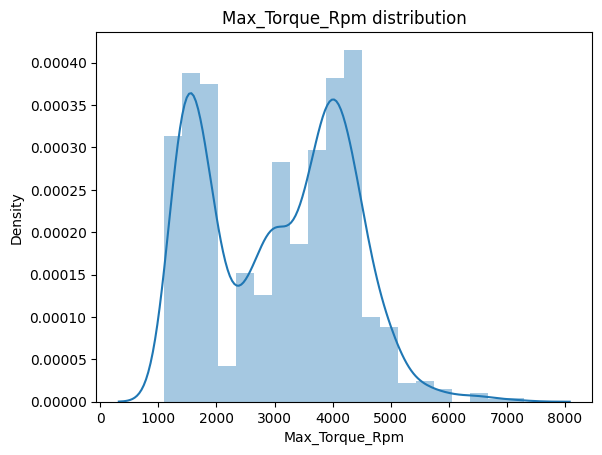

In [304]:
sns.distplot(Linear_Reg_df["Max_Torque_Rpm"],bins = 20)
plt.title('Max_Torque_Rpm distribution')
mean = statistics.mean(Linear_Reg_df['Max_Torque_Rpm'])
median = statistics.median(Linear_Reg_df['Max_Torque_Rpm'])
mode = statistics.mode(Linear_Reg_df['Max_Torque_Rpm'])
print("Max_Torque_Rpm (mean) :",mean)
print("Max_Torque_Rpm (median) :",median)
print("Max_Torque_Rpm (mode) :",mode)
print("Max_Torque_Rpm Skewness: %f" % Linear_Reg_df['Max_Torque_Rpm'].skew())
print("Max_Torque_Rpm Kurtosis: %f" % Linear_Reg_df['Max_Torque_Rpm'].kurt())

Since this feature follows Bimodal distribution we will remove this feature.


In [305]:
Linear_Reg_df = Linear_Reg_df.drop("Max_Torque_Rpm", axis = 1)
Linear_Reg_df.columns

Index(['Max_Power_Rpm', 'Co2_Emissions(g/km)', 'Fuel_Type_gasoline',
       'Fuel_Type_gasoline / bio ethanol', 'Fuel_Type_lpg / gasoline',
       'Cylinders_12, v engine', 'Cylinders_12, w engine',
       'Cylinders_16, w engine', 'Cylinders_2, in line', 'Cylinders_3',
       'Cylinders_3, in line', 'Cylinders_4', 'Cylinders_4, boxer',
       'Cylinders_4, in line', 'Cylinders_4, v engine', 'Cylinders_5, in line',
       'Cylinders_6', 'Cylinders_6, boxer', 'Cylinders_6, in line',
       'Cylinders_6, v engine', 'Cylinders_8, in line',
       'Cylinders_8, v engine', 'Cylinders_8, w engine',
       'Fuel_System_direct injection', 'Fuel_System_indirect injection',
       'Fuel_System_multijet', 'Fuel_System_multipoint injection',
       'Fuel_System_singplepoint injection', 'Turbo_no', 'Turbo_yes',
       'Turbo_yes, two', 'Turbo_yes, with intercooler',
       'Normalized_Engine_Capacity(cc)'],
      dtype='object')

4. Co2_Emissions(g/km)

Co2_Emissions(g/km) (mean) : 186.13840976020194
Co2_Emissions(g/km) (median) : 172.0
Co2_Emissions(g/km) (mode) : 139.0
Co2_Emissions(g/km) Skewness: 1.544662
Co2_Emissions(g/km) Kurtosis: 4.148374


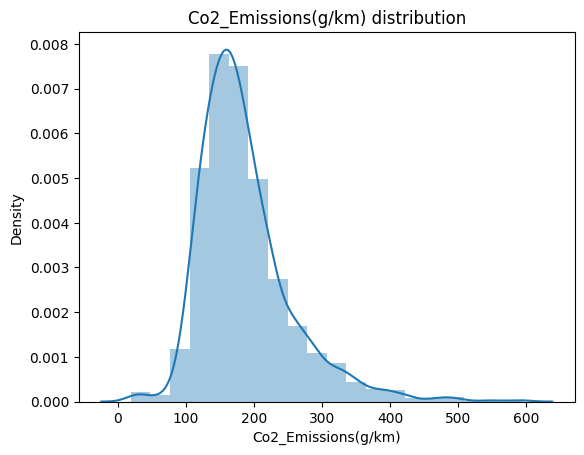

In [306]:
sns.distplot(Linear_Reg_df["Co2_Emissions(g/km)"],bins = 20)
plt.title('Co2_Emissions(g/km) distribution')
mean = statistics.mean(Linear_Reg_df['Co2_Emissions(g/km)'])
median = statistics.median(Linear_Reg_df['Co2_Emissions(g/km)'])
mode = statistics.mode(Linear_Reg_df['Co2_Emissions(g/km)'])
print("Co2_Emissions(g/km) (mean) :",mean)
print("Co2_Emissions(g/km) (median) :",median)
print("Co2_Emissions(g/km) (mode) :",mode)
print("Co2_Emissions(g/km) Skewness: %f" % Linear_Reg_df['Co2_Emissions(g/km)'].skew())
print("Co2_Emissions(g/km) Kurtosis: %f" % Linear_Reg_df['Co2_Emissions(g/km)'].kurt())

Since the Skewness is more than 1, we have to use Log Transform 

In [307]:
Linear_Reg_df["Normalized_Co2_Emissions(g/km)"] = np.log1p(Linear_Reg_df["Co2_Emissions(g/km)"]) 

Normalized_Co2_Emissions(g/km) (mean) : 5.170881913945962
Normalized_Co2_Emissions(g/km) (median) : 5.153291594497778
Normalized_Co2_Emissions(g/km) (mode) : 4.941642422609304
Normalized_Co2_Emissions(g/km) Skewness: -0.430782
Normalized_Co2_Emissions(g/km) Kurtosis: 3.917156


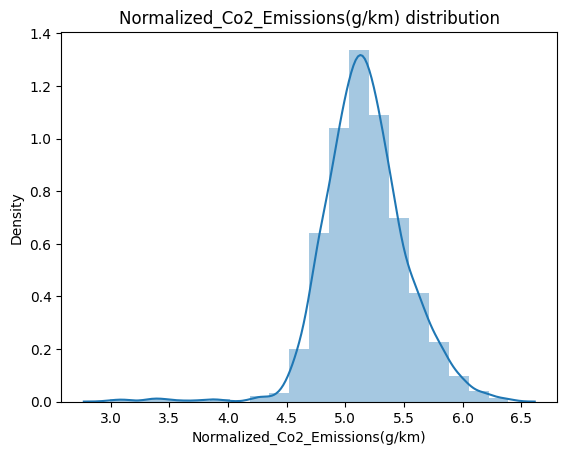

In [308]:
sns.distplot(Linear_Reg_df["Normalized_Co2_Emissions(g/km)"],bins = 20)
plt.title('Normalized_Co2_Emissions(g/km) distribution')
mean = statistics.mean(Linear_Reg_df['Normalized_Co2_Emissions(g/km)'])
median = statistics.median(Linear_Reg_df['Normalized_Co2_Emissions(g/km)'])
mode = statistics.mode(Linear_Reg_df['Normalized_Co2_Emissions(g/km)'])
print("Normalized_Co2_Emissions(g/km) (mean) :",mean)
print("Normalized_Co2_Emissions(g/km) (median) :",median)
print("Normalized_Co2_Emissions(g/km) (mode) :",mode)
print("Normalized_Co2_Emissions(g/km) Skewness: %f" % Linear_Reg_df['Normalized_Co2_Emissions(g/km)'].skew())
print("Normalized_Co2_Emissions(g/km) Kurtosis: %f" % Linear_Reg_df['Normalized_Co2_Emissions(g/km)'].kurt())

In [309]:
Linear_Reg_df.columns

Index(['Max_Power_Rpm', 'Co2_Emissions(g/km)', 'Fuel_Type_gasoline',
       'Fuel_Type_gasoline / bio ethanol', 'Fuel_Type_lpg / gasoline',
       'Cylinders_12, v engine', 'Cylinders_12, w engine',
       'Cylinders_16, w engine', 'Cylinders_2, in line', 'Cylinders_3',
       'Cylinders_3, in line', 'Cylinders_4', 'Cylinders_4, boxer',
       'Cylinders_4, in line', 'Cylinders_4, v engine', 'Cylinders_5, in line',
       'Cylinders_6', 'Cylinders_6, boxer', 'Cylinders_6, in line',
       'Cylinders_6, v engine', 'Cylinders_8, in line',
       'Cylinders_8, v engine', 'Cylinders_8, w engine',
       'Fuel_System_direct injection', 'Fuel_System_indirect injection',
       'Fuel_System_multijet', 'Fuel_System_multipoint injection',
       'Fuel_System_singplepoint injection', 'Turbo_no', 'Turbo_yes',
       'Turbo_yes, two', 'Turbo_yes, with intercooler',
       'Normalized_Engine_Capacity(cc)', 'Normalized_Co2_Emissions(g/km)'],
      dtype='object')

In [310]:
Linear_Reg_df= Linear_Reg_df.drop("Co2_Emissions(g/km)", axis = 1)

In [311]:
Linear_Reg_df.columns

Index(['Max_Power_Rpm', 'Fuel_Type_gasoline',
       'Fuel_Type_gasoline / bio ethanol', 'Fuel_Type_lpg / gasoline',
       'Cylinders_12, v engine', 'Cylinders_12, w engine',
       'Cylinders_16, w engine', 'Cylinders_2, in line', 'Cylinders_3',
       'Cylinders_3, in line', 'Cylinders_4', 'Cylinders_4, boxer',
       'Cylinders_4, in line', 'Cylinders_4, v engine', 'Cylinders_5, in line',
       'Cylinders_6', 'Cylinders_6, boxer', 'Cylinders_6, in line',
       'Cylinders_6, v engine', 'Cylinders_8, in line',
       'Cylinders_8, v engine', 'Cylinders_8, w engine',
       'Fuel_System_direct injection', 'Fuel_System_indirect injection',
       'Fuel_System_multijet', 'Fuel_System_multipoint injection',
       'Fuel_System_singplepoint injection', 'Turbo_no', 'Turbo_yes',
       'Turbo_yes, two', 'Turbo_yes, with intercooler',
       'Normalized_Engine_Capacity(cc)', 'Normalized_Co2_Emissions(g/km)'],
      dtype='object')

Our Data is ready for Linear Regression model and satisfies 3 out of 5 assumptions. The other 2 assumptions will be tested after model training.

In [312]:
Linear_Reg_df.head(2)

,Max_Power_Rpm,Fuel_Type_gasoline,Fuel_Type_gasoline / bio ethanol,Fuel_Type_lpg / gasoline,"Cylinders_12, v engine","Cylinders_12, w engine","Cylinders_16, w engine","Cylinders_2, in line",Cylinders_3,"Cylinders_3, in line",...,Fuel_System_indirect injection,Fuel_System_multijet,Fuel_System_multipoint injection,Fuel_System_singplepoint injection,Turbo_no,Turbo_yes,"Turbo_yes, two","Turbo_yes, with intercooler",Normalized_Engine_Capacity(cc),Normalized_Co2_Emissions(g/km)
0,5500.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,7.221836,5.049856
1,5750.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,7.221836,5.093750


In [313]:
y = Linear_Reg_df["Normalized_Co2_Emissions(g/km)"]
X = Linear_Reg_df.drop("Normalized_Co2_Emissions(g/km)", axis = 1)

In [314]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state = 101
)

If features are on different scales certain weights may update faster than the other ones, so they should be roughly on the same scale.

In [315]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [316]:
# set name for logging
mlflow.set_experiment("Co2 Emission Prediction")
# enable autologging with MLflow
mlflow.sklearn.autolog()

In [317]:
# Train with Linear Regression
mlflow.start_run()
model = LinearRegression()
model.fit(scaled_X_train, y_train)
print("Training Completed.")

test_predictions = model.predict(scaled_X_test)
print("scaled_X_test values predicted. Saved in test_predictions")

#Return to original unit
y_test = np.exp(y_test)
test_predictions = np.exp(test_predictions)

test_residuals = y_test - test_predictions
print("test_residuals found.")

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

# Stop logging for this model
mlflow.end_run()

print("MAE:", MAE)
print("MSE:", MSE)
print("RMSE:", RMSE)

2023/12/27 20:35:49 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Training Completed.
scaled_X_test values predicted. Saved in test_predictions
test_residuals found.
MAE: 24.365882653160188
MSE: 1398.7986853834627
RMSE: 37.40051718069501


In [318]:
Model_Error_rates["Linear Regression"] = RMSE

In [319]:
Count = 0
for index, value in y_test.items():
    print(f"{index} -> Actual value - {value}, Predicted value - {test_predictions[Count]}")
    Count += 1
    if Count == 11:
        break

1123 -> Actual value - 219.00000000000003, Predicted value - 200.43198235334344
2169 -> Actual value - 221.99999999999997, Predicted value - 186.57545641768866
2286 -> Actual value - 122.00000000000003, Predicted value - 105.79589994859906
2050 -> Actual value - 208.99999999999997, Predicted value - 207.77212427363534
1265 -> Actual value - 170.99999999999991, Predicted value - 168.3797019830885
2322 -> Actual value - 71.0, Predicted value - 154.25401321780572
459 -> Actual value - 139.99999999999994, Predicted value - 153.2236435104551
1360 -> Actual value - 266.0, Predicted value - 223.34573236436944
1694 -> Actual value - 156.0, Predicted value - 189.08769049801572
126 -> Actual value - 195.0, Predicted value - 189.26837737324936
1955 -> Actual value - 219.00000000000003, Predicted value - 207.86795940459854


Assumption 3 -> Homoscedasticity

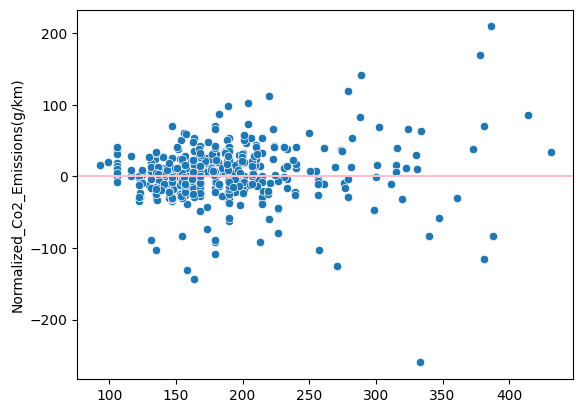

In [320]:
sns.scatterplot(x = test_predictions, y = test_residuals)
plt.axhline(y = 0, color = "pink")
plt.show()

The residuals are good for most of the predictions, only few points have high error rate.  There are equal no of points in both side of the axis y = 0 & but there is some kind of pattern so we will do a test for homoscedasticity.

Assumption 6. Normality of residuals

[]

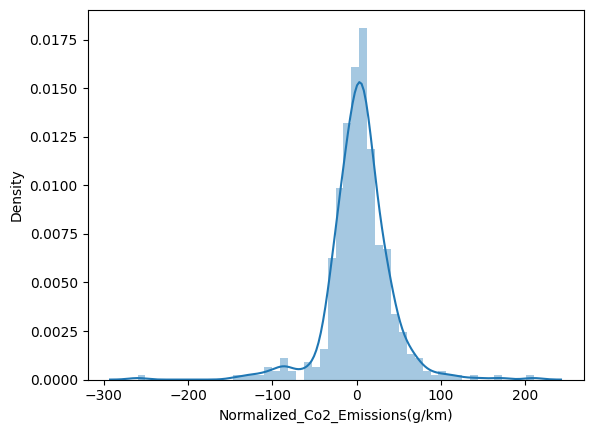

In [321]:
sns.distplot(test_residuals)
plt.plot()

Since the residuals have few high errors, the distribution is in the right side of the graph with mean, median, mode in the same range.

In [322]:
mean = statistics.mean(test_residuals)
median = statistics.median(test_residuals)
mode = statistics.mode(test_residuals)
print("Max_Power_Rpm (mean) :",mean)
print("Max_Power_Rpm (median) :",median)
print("Max_Power_Rpm (mode) :",mode)

Max_Power_Rpm (mean) : 3.457589236426908
Max_Power_Rpm (median) : 3.503484340310095
Max_Power_Rpm (mode) : 2.8236493404114356


<pre>Assumption 4. No Auto correlation
We will use Durbin Watson test to check if there is auto correlation.
If the value is around 2, then no auto correlation.

In [323]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(test_residuals)

2.0334871539507717

The value is 1.9946414838284126. So no auto correlation.

#### Support Vector Regression

In [324]:
SVR_df = Final_df.copy()

In [325]:
SVR_df.head(2)

,Power(kw),Max_Torque(nm),Engine_Capacity(cc),Max_Power_Rpm,Max_Torque_Rpm,Co2_Emissions(g/km),Fuel_Type_gasoline,Fuel_Type_gasoline / bio ethanol,Fuel_Type_lpg / gasoline,"Cylinders_12, v engine",...,"Cylinders_8, w engine",Fuel_System_direct injection,Fuel_System_indirect injection,Fuel_System_multijet,Fuel_System_multipoint injection,Fuel_System_singplepoint injection,Turbo_no,Turbo_yes,"Turbo_yes, two","Turbo_yes, with intercooler"
0,99.0,206.0,1368.0,5500.0,3000.0,155.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,114.0,201.0,1368.0,5750.0,3000.0,162.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [326]:
y = SVR_df["Co2_Emissions(g/km)"]
X = SVR_df.drop("Co2_Emissions(g/km)", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state = 101)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

mlflow.start_run()
param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale'], "kernel" : ['linear', 'poly', 'rbf', 'sigmoid']}
svr_model = SVR()

grid_model = GridSearchCV(estimator=svr_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error')

grid_model.fit(scaled_X_train,y_train)

print(grid_model.best_params_)

test_predictions = grid_model.predict(scaled_X_test)
Test_Residuals = y_test - test_predictions

MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(mean_squared_error(y_test,test_predictions))

mlflow.end_run()

print("MSE:",MSE)
print("RMSE",RMSE)

2023/12/27 20:35:56 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/12/27 20:37:15 INFO mlflow.sklearn.utils: Logging the 5 best runs, 51 runs will be omitted.


{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
MSE: 1064.2439861686137
RMSE 32.62275258417986


In [327]:
Model_Error_rates["SVM"] = RMSE

In [328]:
Count = 0
for index, value in y_test.items():
    print(f"{index} -> Actual value - {value}, Predicted value - {test_predictions[Count]}")
    Count += 1
    if Count == 11:
        break

1123 -> Actual value - 218.0, Predicted value - 199.31139839999526
2169 -> Actual value - 221.0, Predicted value - 196.54493360865365
2286 -> Actual value - 121.0, Predicted value - 119.28055136771627
2050 -> Actual value - 208.0, Predicted value - 203.71208220850016
1265 -> Actual value - 170.0, Predicted value - 167.21932826838804
2322 -> Actual value - 70.0, Predicted value - 172.70865230823523
459 -> Actual value - 139.0, Predicted value - 154.68682409743235
1360 -> Actual value - 265.0, Predicted value - 231.45242815214965
1694 -> Actual value - 155.0, Predicted value - 187.604663893336
126 -> Actual value - 194.0, Predicted value - 190.2020566778731
1955 -> Actual value - 218.0, Predicted value - 160.82165711239017


#### KNN Regression

In [329]:
KNN_df = Final_df.copy()

In [330]:
KNN_df.head(2)

,Power(kw),Max_Torque(nm),Engine_Capacity(cc),Max_Power_Rpm,Max_Torque_Rpm,Co2_Emissions(g/km),Fuel_Type_gasoline,Fuel_Type_gasoline / bio ethanol,Fuel_Type_lpg / gasoline,"Cylinders_12, v engine",...,"Cylinders_8, w engine",Fuel_System_direct injection,Fuel_System_indirect injection,Fuel_System_multijet,Fuel_System_multipoint injection,Fuel_System_singplepoint injection,Turbo_no,Turbo_yes,"Turbo_yes, two","Turbo_yes, with intercooler"
0,99.0,206.0,1368.0,5500.0,3000.0,155.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,114.0,201.0,1368.0,5750.0,3000.0,162.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [331]:
y = KNN_df["Co2_Emissions(g/km)"]
X = KNN_df.drop("Co2_Emissions(g/km)", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state = 101)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

mlflow.start_run()

param_grid = {"n_neighbors" : [1,5,10]}
knn_model = KNeighborsRegressor()

grid_model = GridSearchCV(estimator=knn_model,param_grid=param_grid,scoring='neg_mean_squared_error')

grid_model.fit(scaled_X_train,y_train)

print(grid_model.best_params_)

test_predictions = grid_model.predict(scaled_X_test)
Test_Residuals = y_test - test_predictions

MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(mean_squared_error(y_test,test_predictions))

mlflow.end_run()

print("MSE:",MSE)
print("RMSE",RMSE)

2023/12/27 20:37:18 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/12/27 20:37:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


{'n_neighbors': 5}
MSE: 994.0272268907562
RMSE 31.528197330179793


In [332]:
Model_Error_rates["KNN"] = RMSE

In [333]:
Count = 0
for index, value in y_test.items():
    print(f"{index} -> Actual value - {value}, Predicted value - {test_predictions[Count]}")
    Count += 1
    if Count == 11:
        break

1123 -> Actual value - 218.0, Predicted value - 192.4
2169 -> Actual value - 221.0, Predicted value - 202.6
2286 -> Actual value - 121.0, Predicted value - 108.6
2050 -> Actual value - 208.0, Predicted value - 207.6
1265 -> Actual value - 170.0, Predicted value - 173.4
2322 -> Actual value - 70.0, Predicted value - 122.6
459 -> Actual value - 139.0, Predicted value - 165.8
1360 -> Actual value - 265.0, Predicted value - 213.0
1694 -> Actual value - 155.0, Predicted value - 167.8
126 -> Actual value - 194.0, Predicted value - 198.6
1955 -> Actual value - 218.0, Predicted value - 207.6


Decision Tree Regression

In [334]:
DT_df = Final_df.copy()

In [335]:
DT_df.head(2)

,Power(kw),Max_Torque(nm),Engine_Capacity(cc),Max_Power_Rpm,Max_Torque_Rpm,Co2_Emissions(g/km),Fuel_Type_gasoline,Fuel_Type_gasoline / bio ethanol,Fuel_Type_lpg / gasoline,"Cylinders_12, v engine",...,"Cylinders_8, w engine",Fuel_System_direct injection,Fuel_System_indirect injection,Fuel_System_multijet,Fuel_System_multipoint injection,Fuel_System_singplepoint injection,Turbo_no,Turbo_yes,"Turbo_yes, two","Turbo_yes, with intercooler"
0,99.0,206.0,1368.0,5500.0,3000.0,155.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,114.0,201.0,1368.0,5750.0,3000.0,162.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [336]:
y = DT_df["Co2_Emissions(g/km)"]
X = DT_df.drop("Co2_Emissions(g/km)", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state = 101)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

mlflow.start_run()
param_grid = {}
DT_model = DecisionTreeRegressor()

grid_model = GridSearchCV(estimator=DT_model,param_grid=param_grid,scoring='neg_mean_squared_error')

grid_model.fit(scaled_X_train,y_train)

print(grid_model.best_params_)

test_predictions = grid_model.predict(scaled_X_test)
Test_Residuals = y_test - test_predictions

MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(mean_squared_error(y_test,test_predictions))

mlflow.end_run()

print("MSE:",MSE)
print("RMSE",RMSE)

2023/12/27 20:37:25 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/12/27 20:37:30 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


{}
MSE: 1090.7829761948506
RMSE 33.02700374231442


In [337]:
Model_Error_rates["DT"] = RMSE

In [338]:
Count = 0
for index, value in y_test.items():
    print(f"{index} -> Actual value - {value}, Predicted value - {test_predictions[Count]}")
    Count += 1
    if Count == 11:
        break

1123 -> Actual value - 218.0, Predicted value - 218.5
2169 -> Actual value - 221.0, Predicted value - 203.0
2286 -> Actual value - 121.0, Predicted value - 125.0
2050 -> Actual value - 208.0, Predicted value - 175.0
1265 -> Actual value - 170.0, Predicted value - 175.5
2322 -> Actual value - 70.0, Predicted value - 166.25
459 -> Actual value - 139.0, Predicted value - 119.0
1360 -> Actual value - 265.0, Predicted value - 236.0
1694 -> Actual value - 155.0, Predicted value - 219.0
126 -> Actual value - 194.0, Predicted value - 192.0
1955 -> Actual value - 218.0, Predicted value - 235.5


#### Random Forest

In [339]:
RF_df = Final_df.copy()

In [340]:
RF_df.head(2)

,Power(kw),Max_Torque(nm),Engine_Capacity(cc),Max_Power_Rpm,Max_Torque_Rpm,Co2_Emissions(g/km),Fuel_Type_gasoline,Fuel_Type_gasoline / bio ethanol,Fuel_Type_lpg / gasoline,"Cylinders_12, v engine",...,"Cylinders_8, w engine",Fuel_System_direct injection,Fuel_System_indirect injection,Fuel_System_multijet,Fuel_System_multipoint injection,Fuel_System_singplepoint injection,Turbo_no,Turbo_yes,"Turbo_yes, two","Turbo_yes, with intercooler"
0,99.0,206.0,1368.0,5500.0,3000.0,155.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,114.0,201.0,1368.0,5750.0,3000.0,162.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [341]:
y = RF_df["Co2_Emissions(g/km)"]
X = RF_df.drop("Co2_Emissions(g/km)", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state = 101)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

mlflow.start_run()

RF_model = RandomForestRegressor()

param_grid = {"n_estimators": [10,25,50,75,100]}
grid_model = GridSearchCV(estimator = RF_model, param_grid=param_grid,scoring='neg_mean_squared_error')

grid_model.fit(scaled_X_train,y_train)

print(grid_model.best_params_)

test_predictions = grid_model.predict(scaled_X_test)
Test_Residuals = y_test - test_predictions

MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(mean_squared_error(y_test,test_predictions))

mlflow.end_run()

print("MSE:",MSE)
print("RMSE",RMSE)

2023/12/27 20:37:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/12/27 20:37:43 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


{'n_estimators': 25}
MSE: 690.1782197560149
RMSE 26.271243209182447


In [342]:
Model_Error_rates["RF"] = RMSE

In [343]:
Count = 0
for index, value in y_test.items():
    print(f"{index} -> Actual value - {value}, Predicted value - {test_predictions[Count]}")
    Count += 1
    if Count == 11:
        break

1123 -> Actual value - 218.0, Predicted value - 213.944
2169 -> Actual value - 221.0, Predicted value - 201.53400000000002
2286 -> Actual value - 121.0, Predicted value - 121.55333333333333
2050 -> Actual value - 208.0, Predicted value - 185.49666666666667
1265 -> Actual value - 170.0, Predicted value - 175.58333333333337
2322 -> Actual value - 70.0, Predicted value - 156.39666666666665
459 -> Actual value - 139.0, Predicted value - 149.38
1360 -> Actual value - 265.0, Predicted value - 262.28
1694 -> Actual value - 155.0, Predicted value - 195.59999999999997
126 -> Actual value - 194.0, Predicted value - 197.64
1955 -> Actual value - 218.0, Predicted value - 215.09866666666665


#### Best Model

In [344]:
Best_Model = sorted(Model_Error_rates.items(), key=lambda item: item[1])

In [345]:
Best_Model

[('RF', 26.271243209182447),
 ('KNN', 31.528197330179793),
 ('SVM', 32.62275258417986),
 ('DT', 33.02700374231442),
 ('Linear Regression', 37.40051718069501)]

Random Forest is the best model with the lowest RMSE value.

<center>
<h3>Thank You!</h3>
</center>